The dataset contains two folders 'annotations' and 'images'.<br>
annotations contains .xml files with image data and images contains png files <br>
.xml is a markup  file commonly associated with webscraped data and stands for <br>
"Extensible Markup Language"<br>
these files contain elements within <>and the element info inbetween eg:

\</movie><br>
\<movie favorite="False" title="Back 2 the Future"><br>
$\qquad$    \<format multiple="False">Blu-ray</format><br>
$\qquad$   \<year>1985</year><br>
$\qquad$   \<rating>PG</rating><br>
$\qquad$    \<description>Marty McFly</description><br>
\</movie><br>

the [] after the root indicates how deep in the feature tree root we are

on initial inspection the main properties we want are the file name image size and object bndbox

In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
xml_path = 'annotations/'
png_path = 'images/'

In [3]:
#read in xml files and image names to dict to make a dataframe
final_dictionary = {'image_name':[],'image_dims':[]}

#fill dict with 115 (max) objectsfor appending
for i in range(1,116,1):
    final_dictionary[f'object {i}']=[]

for file in os.listdir(xml_path):
    tree = ET.parse(xml_path+file)
    root = tree.getroot()
    img_data = []
    #append img filename
    img_data.append(root[1].text)
    #append img dimensions (height,width)
    img_data.append([root[2][1].text,root[2][0].text])
    
    #read in object data
    for i in range(4,len(root)):
        tmp = []
        
        #append mask status
        tmp.append(root[i][0].text)
        
        #apend y and x max/min
        for coords in root[i][5]:
            tmp.append(coords.text)
        img_data.append(tmp)
        
        #max xml length objects is 115 long so we need 
        #to fill equal columns so dataframe is uniform size
    for i in range(len(img_data),119):
        img_data.append(0)

    for i, key in enumerate(final_dictionary):
        final_dictionary[key].append(img_data[i])

In [4]:
df = pd.DataFrame(final_dictionary)

In [5]:
df['image_dims'].sort_values().head(50)

1      [156, 400]
310    [188, 400]
294    [197, 400]
508    [198, 400]
811    [200, 400]
73     [200, 400]
835    [200, 400]
122    [200, 400]
680    [200, 400]
233    [200, 400]
413    [200, 400]
100    [200, 400]
454    [200, 400]
59     [200, 400]
416    [203, 400]
170    [206, 400]
191    [208, 400]
248    [208, 400]
592    [209, 400]
304    [209, 400]
365    [210, 400]
569    [210, 400]
746    [210, 400]
515    [210, 400]
76     [210, 400]
123    [210, 400]
602    [210, 400]
350    [210, 400]
493    [210, 400]
163    [210, 400]
159    [210, 400]
805    [210, 400]
342    [210, 400]
494    [210, 400]
433    [211, 400]
723    [211, 400]
388    [216, 400]
430    [217, 400]
51     [217, 400]
173    [217, 400]
841    [217, 400]
328    [218, 400]
95     [220, 400]
308    [221, 400]
691    [221, 400]
220    [221, 400]
738    [225, 400]
344    [225, 400]
674    [225, 400]
151    [225, 400]
Name: image_dims, dtype: object

In [6]:
(df.dtypes != 'object').sum()

0

In [7]:
face_num = []
target_face_label = []

label_dict = {'without_mask':0,'with_mask':1,'mask_weared_incorrect':2}

# need to ensure im using same img and xml
for i in range(0,853):
    img_file_name = 'maksssksksss' + str(i) + '.png'
    
    num_faces=int(len(df.columns)-2-(df[df['image_name']==img_file_name]==0).sum(axis=1))
    box_coords = []
    labels = []
    for j in range(1,(1+num_faces)):
        df_slice = df[df['image_name']==img_file_name][f'object {j}']

        #boxes
        xmin = int(df_slice.apply(lambda x: x[1]))
        ymin = int(df_slice.apply(lambda x: x[2]))
        xmax = int(df_slice.apply(lambda x: x[3]))
        ymax = int(df_slice.apply(lambda x: x[4]))
        box_coords.append([xmin,ymin,xmax,ymax])
        label = label_dict[df_slice.apply(lambda x: x[0]).values[0]]
        labels.append(label)
    box_coords = np.array(box_coords)
    labels = np.array(labels)
    
    #save as dict so i can loop through face num and image box simultaneously 
    target = {'boxes':box_coords,'labels':labels}
    target_face_label.append(target)
                  
    face_num.append(num_faces)

Great success

In [8]:
int(len(df.columns)-2-(df[df['image_name']=='maksssksksss0.png']==0).sum(axis=1))

3

In [9]:
print(len(target_face_label),len(face_num))

853 853


In [10]:
#we will use the face_num, and target_face_label to extract the 
#face images (boxes) and labels
#Mobilenet suggests an image input size of (224, 224, 3).
#https://keras.io/api/applications/mobilenet/#mobilenetv2-function
face_img = []
img_label = []

for i in range(0,853):
    file_name = 'maksssksksss' + str(i) + '.png'    
    img = cv2.imread(png_path+file_name)
    
    for j in range(face_num[i]):
        box = target_face_label[i]['boxes'][j]
        
        #cut and resize img remembering cv2 reads y then x
        cut_img = img[box[1]:box[3],box[0]:box[2]]
        resize_img =cv2.resize(cut_img,(224,224))
        img_array = img_to_array(resize_img)
        final_img = preprocess_input(img_array)
        #append
        face_img.append(final_img)
        img_label.append(target_face_label[i]['labels'][j])
        
face_img = np.array(face_img,dtype='float32')
img_label = np.array(img_label)

In [11]:
face_img.shape

(4072, 224, 224, 3)

In [12]:
#labels need to be one hot encoded
np.unique(img_label,return_counts=True)

(array([0, 1, 2]), array([ 717, 3232,  123], dtype=int64))

imbalenced classes<br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

we will generate after train_test split to make classes more balenced

# Modeling and data processing 

To model this problem we need to determine the best CNN framework avalible. MobileNet (https://arxiv.org/pdf/1704.04861.pdf / https://arxiv.org/abs/1801.04381) seems like an obvious choice as it is mall in size and computationally faster than a full CNN. These factors make MobileNet more attractive when thinking of implementing this model in a real world scenario (shown in workbook 2).

In [13]:
#Data is in face_img, img_label
LE = LabelEncoder()
labels = LE.fit_transform(img_label)
labels = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(face_img, labels, test_size=0.2, random_state=930609, stratify=labels)

In [14]:
#set up data generator
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             fill_mode='nearest',
                             horizontal_flip=True,
                             vertical_flip=False,
                             rescale=0,
                             dtype='float32')

In [15]:
#define the model
base_model = MobileNetV2(weights="imagenet", 
                        include_top=False, 
                        input_shape=(224, 224, 3))

# the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(224, activation="relu")(head_model)
head_model = Dropout(0.25)(head_model)
head_model = Dense(3, activation="softmax")(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
    layer.trainable = False

In [16]:
model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])

In [18]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

model.fit(datagen.flow(X_train, y_train),
          validation_data=(X_train, y_train),
          epochs=25,
          callbacks=[early_stop]) 

Epoch 1/25
102/102 [==============================] - 105s 1s/step - loss: 0.2554 - accuracy: 0.9039 - val_loss: 0.2168 - val_accuracy: 0.9239
Epoch 2/25
102/102 [==============================] - 108s 1s/step - loss: 0.2285 - accuracy: 0.9171 - val_loss: 0.1945 - val_accuracy: 0.9263
Epoch 3/25
102/102 [==============================] - 108s 1s/step - loss: 0.2061 - accuracy: 0.9248 - val_loss: 0.1971 - val_accuracy: 0.9251
Epoch 4/25
102/102 [==============================] - 109s 1s/step - loss: 0.1912 - accuracy: 0.9315 - val_loss: 0.2052 - val_accuracy: 0.9340
Epoch 5/25
102/102 [==============================] - 109s 1s/step - loss: 0.2012 - accuracy: 0.9288 - val_loss: 0.1684 - val_accuracy: 0.9371
Epoch 6/25
102/102 [==============================] - 112s 1s/step - loss: 0.1876 - accuracy: 0.9328 - val_loss: 0.1689 - val_accuracy: 0.9432
Epoch 7/25
102/102 [==============================] - 110s 1s/step - loss: 0.1901 - accuracy: 0.9269 - val_loss: 0.1474 - val_accuracy: 0.9441

<AxesSubplot:>

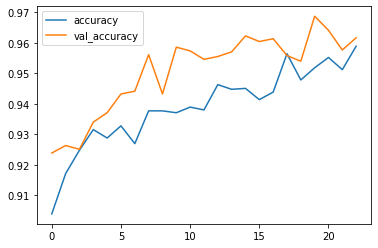

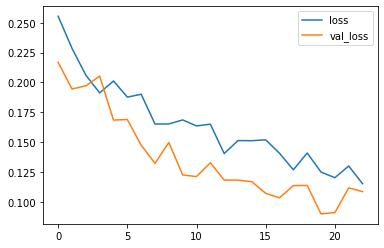

In [19]:
losses = pd.DataFrame(model.history.history)
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

In [22]:
predictions = model.predict(X_test)

In [25]:
predictions = np.argmax(predictions, axis=1)
predictions

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0,

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), predictions))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86       143
           1       0.97      0.95      0.96       647
           2       0.79      0.44      0.56        25

    accuracy                           0.93       815
   macro avg       0.85      0.77      0.79       815
weighted avg       0.93      0.93      0.93       815



In [28]:
#save model to json and weights to h5
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

In [ ]:
#how to load
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")